# Sentiment model with CNNs

 - Use Convolutions to create a sentiment model.
 - Based on: http://www.wildml.com/2015/12/implementing-a-cnn-for-text-classification-in-tensorflow/ 

In [1]:
#Imports 
from __future__ import print_function

import numpy as np

import tensorflow as tf
print(tf.__version__)

data_path='/home/ubuntu/data/training/keras/aclImdb/'


0.12.0


## Read data and create sequences

In [2]:
# Generator of list of files in a folder and subfolders
import os
import fnmatch

def gen_find(filefilter, top):
    for path, dirlist, filelist in os.walk(top):
        for name in fnmatch.filter(filelist, filefilter):
            yield os.path.join(path, name)

def read_sentences(path):
    sentences = []
    sentences_list = gen_find("*.txt", path)
    for ff in sentences_list:
        with open(ff, 'r') as f:
            sentences.append(f.readline().strip())
    return sentences 

In [3]:
# Read train sentences and create train target

sentences_trn_pos = read_sentences(data_path+'train/pos/')
sentences_trn_neg = read_sentences(data_path+'train/neg/')

sentences_trn_ini = sentences_trn_pos + sentences_trn_neg
print('max_document_length trn: ', max([len(x.split(" ")) for x in sentences_trn_ini]))

y_trn_ini = np.array([[1.,0.]]*len(sentences_trn_pos) + [[0.,1.]]*len(sentences_trn_neg), dtype=np.float32)

print(y_trn_ini.shape)
print(y_trn_ini)


max_document_length trn:  2470
(25000, 2)
[[ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 ..., 
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]]


In [4]:
# Shuffle train data
from sklearn.utils import shuffle
sentences_trn, y_trn = shuffle(sentences_trn_ini, y_trn_ini)

print(y_trn)

[[ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 ..., 
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]]


In [5]:
# Read test sentences and create test target

sentences_tst_pos = read_sentences(data_path+'test/pos/')
sentences_tst_neg = read_sentences(data_path+'test/neg/')

sentences_tst = sentences_tst_pos + sentences_tst_neg
print('max_document_length tst: ', max([len(x.split(" ")) for x in sentences_tst]))

y_tst = np.array([[1.,0.]]*len(sentences_tst_pos) + [[0.,1.]]*len(sentences_tst_neg), dtype=np.float32)

print(y_tst.shape)


max_document_length tst:  2278
(25000, 2)


In [6]:
# Build vocabulary and transform sentences
from tensorflow.contrib import learn

sequence_length  =100

# Train vocab and apply to train
vocab_processor = learn.preprocessing.VocabularyProcessor(sequence_length, min_frequency=10)
X_trn = np.array(list(vocab_processor.fit_transform(sentences_trn)))

# Apply trained vocab to test 
X_tst = np.array(list(vocab_processor.transform(sentences_tst)))

# Size vocabulary
vocab_size = len(vocab_processor.vocabulary_)

# Check results
print('Vocab size: ', vocab_size)
print('X trn shape: ', X_trn.shape)
print('X tst shape: ', X_tst.shape)
print('First sentence: ', X_trn[0])
print('house id: ', vocab_processor.vocabulary_.get('house'))

Vocab size:  21761
X trn shape:  (25000, 100)
X tst shape:  (25000, 100)
First sentence:  [  153     3   209   691    17  4726     2    12   529    13    39    82
     9   422  3013    18    24    58     1   161    20    93     1   186
     2     1   360 11863     4     3  1520    34   169   283    23   292
    52    18    12  6141     7     7   768     1   456  1579   545    46
    86  8049   648     4     3   783     2    30     0    46   484    40
   810  1065    26    78    51   274    36     3  1091    48  1187     2
   884  2629  5938   397   396   217     9   487    30     1  2629  5938
   454   160    12   633     9   702   183   255    21     2   646   160
  2245 16604   371   148]
house id:  417


## The model
 - Declare placeholders
 - Embedding layers
 - Convolutional and max pooling layers
 - Merge convolutions oputput
 - Dense layer to predictions

In [7]:
# Model parameters
embedding_size = 128
num_filters = 32
filter_sizes = [3, 6, 12]

In [8]:
# Start an interactive session
gpu_options = tf.GPUOptions(allow_growth = True)
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options, log_device_placement=True))


In [9]:
# Inputs
input_x = tf.placeholder(tf.int32, shape=[None, sequence_length], name="input_x")
print(input_x)

input_y = tf.placeholder(tf.int32, shape=[None, 2], name="input_y")
print(input_y)

dropout_keep_prob = tf.placeholder(tf.float32, name="dropout_keep_prob")


Tensor("input_x:0", shape=(?, 100), dtype=int32)
Tensor("input_y:0", shape=(?, 2), dtype=int32)


In [10]:
# Embedding layer
with tf.name_scope("embedding"):
    W_embedding = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0), name="W_embedding")
    embedded_chars = tf.nn.embedding_lookup(W_embedding, input_x)
    print(embedded_chars)
    
    # Add an aditional dimension to match to the convolution requirements
    embedded_chars_expanded = tf.expand_dims(embedded_chars, -1)
    print(embedded_chars_expanded)
    

Tensor("embedding/embedding_lookup:0", shape=(?, 100, 128), dtype=float32)
Tensor("embedding/ExpandDims:0", shape=(?, 100, 128, 1), dtype=float32)


In [11]:
# Create a convolution + maxpool layer for each filter size

def conv_layer(x, size_x=2, size_y=2, input_channels=1, output_channels=32):
    W_conv = tf.Variable(tf.truncated_normal([size_x, size_y, input_channels, output_channels], stddev=0.1), name='W')
    
    b_conv = tf.Variable(tf.constant(0.1, shape=[output_channels]), name='b')
    
    conv_out = tf.nn.relu(tf.nn.conv2d(x, W_conv, strides=[1, 1, 1, 1], padding='VALID') + b_conv, name='conv')
    
    pooled = tf.nn.max_pool(conv_out, 
                            ksize=[1, sequence_length - filter_size + 1, 1, 1], 
                            strides=[1, 1, 1, 1], 
                            padding='VALID', 
                            name="pool")
    return pooled


pooled_outputs = []
for i, filter_size in enumerate(filter_sizes):
    with tf.name_scope("conv-maxpool-%s" % filter_size):
        pooled = conv_layer(embedded_chars_expanded, size_x=filter_size, size_y=embedding_size, input_channels=1, output_channels=num_filters)
        pooled_outputs.append(pooled)

print(pooled_outputs)

[<tf.Tensor 'conv-maxpool-3/pool:0' shape=(?, 1, 1, 32) dtype=float32>, <tf.Tensor 'conv-maxpool-6/pool:0' shape=(?, 1, 1, 32) dtype=float32>, <tf.Tensor 'conv-maxpool-12/pool:0' shape=(?, 1, 1, 32) dtype=float32>]


In [12]:
# Combine all the pooled features
h_pool = tf.concat(3, pooled_outputs)
print(h_pool)

# Reshape to flat the tensor: f
num_filters_total = num_filters * len(filter_sizes)
h_pool_flat = tf.reshape(h_pool, [-1, num_filters_total])
print(h_pool_flat)

Tensor("concat:0", shape=(?, 1, 1, 96), dtype=float32)
Tensor("Reshape:0", shape=(?, 96), dtype=float32)


In [13]:
# Add dropout
with tf.name_scope("dropout"):
    h_drop = tf.nn.dropout(h_pool_flat, dropout_keep_prob)


In [14]:
# Final (unnormalized) scores and predictions
with tf.name_scope("output"):
    W = tf.get_variable("W", shape=[num_filters_total, 2], initializer=tf.contrib.layers.xavier_initializer())
    b = tf.Variable(tf.constant(0.1, shape=[2]), name="b")
    
    # scores = h_drop * W + b
    scores = tf.nn.xw_plus_b(h_drop, W, b, name="scores")
    print(scores)
    
    # predictions: position of the max value of scores
    predictions = tf.argmax(scores, 1, name="predictions")
    print(predictions)

Tensor("output/scores:0", shape=(?, 2), dtype=float32)
Tensor("output/predictions:0", shape=(?,), dtype=int64)


In [15]:
# Calculate the Mean of the cross-entropy loss in the batch
with tf.name_scope("loss"):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(scores, input_y), name='loss')


In [16]:
# Accuracy: percent of correct predictions
with tf.name_scope("accuracy"):
    accuracy = tf.reduce_mean(tf.cast(tf.equal(predictions, tf.argmax(input_y, 1)), "float"), name="accuracy")

In [17]:
#Optimizer
with tf.name_scope("train") as scope:
    train_step = tf.train.AdamOptimizer(1e-3).minimize(loss)


# Training procces
 - Create a generator to create the batches of inputs and targets. Train & test.
 - Iterate over the data to train the model
   - Each iteration over all the data is an epoch
   - For each epoch iterate overt the batches

In [18]:
def batch_iter(X, y, batch_size):
    """
    Generates a batch iterator for inputs (X) and targets (y) of batch_size size.
    """
    data_size = len(X)
    # Shuffle the data at each epoch
    shuffle_indices = np.random.permutation(np.arange(data_size))    
    shuffled_X = X[shuffle_indices]
    shuffled_y = y[shuffle_indices]
        
    num_batches = int((data_size-1)/batch_size) + 1
    for batch_num in range(num_batches):
        start_index = batch_num * batch_size
        end_index = min((batch_num + 1) * batch_size, data_size)
        yield shuffled_X[start_index:end_index], shuffled_y[start_index:end_index]
        
# Test the generator function      
b_iter= batch_iter(X_trn, y_trn, 2)
print(b_iter.next())

(array([[  224,     1,   786,     4,     3,     0,    13,    10,  1627,
          116,    82,   331,   312,     2,     1,   263,  4288,   783,
          141,   131,   386,   662,    14,    58,   714,   156,   145,
           13,     0,    34,    61,     3,   341,  2074,    15,     3,
        10248,    44,  1123,   327,     1,   354,     4,     1,    19,
            6,   406,     2,   365,   119,    24,    64,    39,    82,
           26,    66,   487,    41,    11,   560,  1069,   633,   106,
         3857, 11176,    12,     5,     1,  2458,  1226,  4213,   240,
           15,    87,  1790, 14855, 14828,     5,  7230,  1701,    87,
         6614,    30,   217,    68,    13,  7773,  7687,     8, 14855,
        14828,   309,    44,     4,   163,     0,     0,     0,     0,
            0],
       [   45, 12515,  1893,    19,     6,   251,  6415,     5,   413,
            3,  1334,   368,  2102,    75,   132,    73,  1625,     4,
            1,  4867, 12479,    44,    68,     9,    64,   4

In [19]:
#Inicialization.
sess.run(tf.global_variables_initializer())

# Train proccess parameters
num_epochs = 20
batch_size = 128

loss_trn_epoch = []
loss_tst_epoch = []
acc_trn_epoch = []
acc_tst_epoch = []

for epoch in range(num_epochs):
    loss_trn = []
    acc_trn = []
    loss_tst = []
    acc_tst = []
    
    # Train step
    for x_batch, y_batch in batch_iter(X_trn, y_trn, batch_size):
        train_step.run(feed_dict={input_x: x_batch, input_y: y_batch, dropout_keep_prob: 0.5})
        loss_step, acc_step = sess.run([loss, accuracy], 
                                       feed_dict={input_x: x_batch, input_y: y_batch, dropout_keep_prob: 1})
        loss_trn += [loss_step]
        acc_trn += [acc_step]
    
    # Validation step
    for x_batch_test, y_batch_test in batch_iter(X_tst, y_tst, batch_size):
        loss_step, acc_step = sess.run([loss, accuracy], 
                                       feed_dict={input_x: x_batch_test, input_y: y_batch_test, dropout_keep_prob: 1})
        loss_tst += [loss_step]
        acc_tst += [acc_step]
    
    # Summary
    print(epoch, np.mean(loss_trn), np.mean(acc_trn), np.mean(loss_tst), np.mean(acc_tst))
    loss_trn_epoch += [np.mean(loss_trn)]
    loss_tst_epoch += [np.mean(loss_tst)]
    acc_trn_epoch += [np.mean(acc_trn)]
    acc_tst_epoch += [np.mean(acc_tst)]
    

0 0.727666 0.585196 0.654947 0.612915
1 0.61425 0.694149 0.646389 0.667195
2 0.6116 0.740609 0.622049 0.697704
3 0.577645 0.750367 0.608896 0.652519
4 0.540379 0.775343 0.57499 0.697895
5 0.497367 0.792769 0.539301 0.728683
6 0.435658 0.832876 0.515183 0.739621
7 0.371692 0.864931 0.490399 0.759208
8 0.298081 0.89898 0.479837 0.76753
9 0.230177 0.929353 0.478223 0.774306
10 0.167533 0.954839 0.502586 0.771006
11 0.115544 0.974011 0.517476 0.776754
12 0.0771081 0.98632 0.549173 0.777129
13 0.0514949 0.993104 0.574853 0.779265
14 0.0348384 0.996524 0.61709 0.777766
15 0.0235893 0.998525 0.650424 0.778707
16 0.0167062 0.999283 0.690798 0.775861
17 0.0120797 0.999681 0.731185 0.77791
18 0.00899534 0.999721 0.76118 0.778316
19 0.00710625 0.999801 0.801183 0.773445
20 0.00543528 0.99992 0.842062 0.776299
21 0.00450631 0.999841 0.875954 0.774346
22 0.00379325 0.99992 0.912555 0.776666
23 0.0030486 0.99992 0.937864 0.774928
24 0.00239829 0.99992 0.984604 0.775805
25 0.00207962 0.99996 1.00826 

## Results

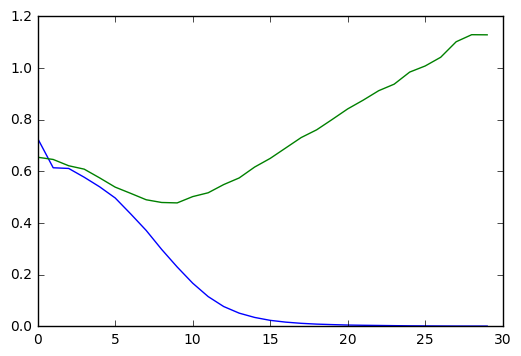

In [20]:
# Plot loss
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(loss_trn_epoch)
plt.plot(loss_tst_epoch)
plt.show()

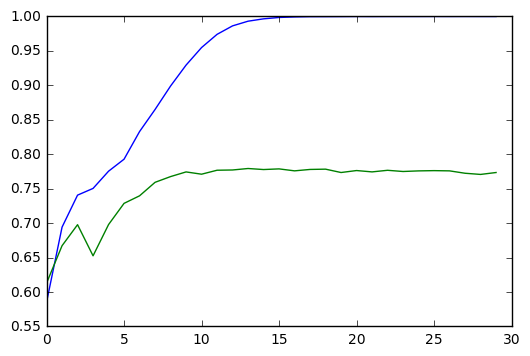

In [21]:
# Plot accuracy
plt.plot(acc_trn_epoch)
plt.plot(acc_tst_epoch)
plt.show()